In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as fit

In [326]:
df = pd.read_csv("GlobalLandTemperaturesByState.csv")
df = df[["dt", "AverageTemperature", "State"]]
df = df[df["dt"].str[:4] > "2000"]
df = df[(df["State"] == "Wyoming") | (df["State"] == "Nebraska") | (df["State"] == "South Dakota")]
df

,dt,AverageTemperature,State
350773,2001-01-01,-2.592,Nebraska
350774,2001-02-01,-5.575,Nebraska
350775,2001-03-01,2.077,Nebraska
350776,2001-04-01,10.431,Nebraska
350777,2001-05-01,15.878,Nebraska
...,...,...,...
626435,2013-05-01,10.607,Wyoming
626436,2013-06-01,16.267,Wyoming
626437,2013-07-01,20.222,Wyoming
626438,2013-08-01,19.621,Wyoming


In [328]:
avg_temp_df = df.groupby("dt")["AverageTemperature"].mean().reset_index()
avg_temp_df.columns = ["Date", "AverageTemperature"]
avg_temp_df

,Date,AverageTemperature
0,2001-01-01,-4.480333
1,2001-02-01,-7.541000
2,2001-03-01,0.590333
3,2001-04-01,7.889000
4,2001-05-01,13.908667
...,...,...
148,2013-05-01,13.196000
149,2013-06-01,18.783667
150,2013-07-01,22.110333
151,2013-08-01,21.890000


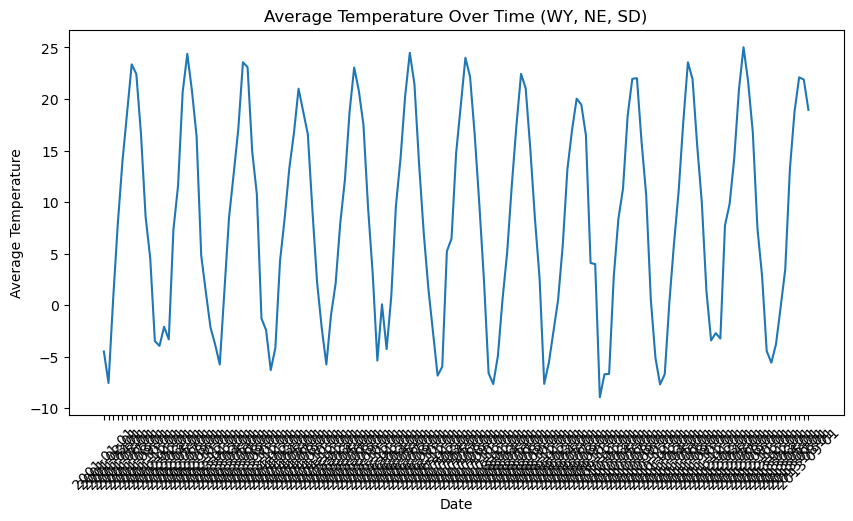

In [330]:
plt.figure(figsize=(10,5))
plt.plot(avg_temp_df["Date"], avg_temp_df["AverageTemperature"])
plt.xlabel("Date")
plt.ylabel("Average Temperature")
plt.title("Average Temperature Over Time (WY, NE, SD)")
plt.xticks(rotation=45)
plt.show()

In [332]:
def date_convert(date_str):
    parts = date_str.split("-")
    year = int(parts[0])
    month = int(parts[1])
    return year + (month - 1) / 12
    
avg_temp_df["ConvertedDate"] = avg_temp_df["Date"].apply(date_convert)
avg_temp_df

,Date,AverageTemperature,ConvertedDate
0,2001-01-01,-4.480333,2001.000000
1,2001-02-01,-7.541000,2001.083333
2,2001-03-01,0.590333,2001.166667
3,2001-04-01,7.889000,2001.250000
4,2001-05-01,13.908667,2001.333333
...,...,...,...
148,2013-05-01,13.196000,2013.333333
149,2013-06-01,18.783667,2013.416667
150,2013-07-01,22.110333,2013.500000
151,2013-08-01,21.890000,2013.583333


In [334]:
def f(x, A, B, C, D):
    return A * np.cos(B * x + C) + D

t0 = [10, 2 * np.pi, 0, 5]

params, covar = fit.curve_fit(f, avg_temp_df["ConvertedDate"], avg_temp_df['AverageTemperature'], t0)

y_est = f(avg_temp_df["ConvertedDate"], params[0], params[1], params[2], params[3])

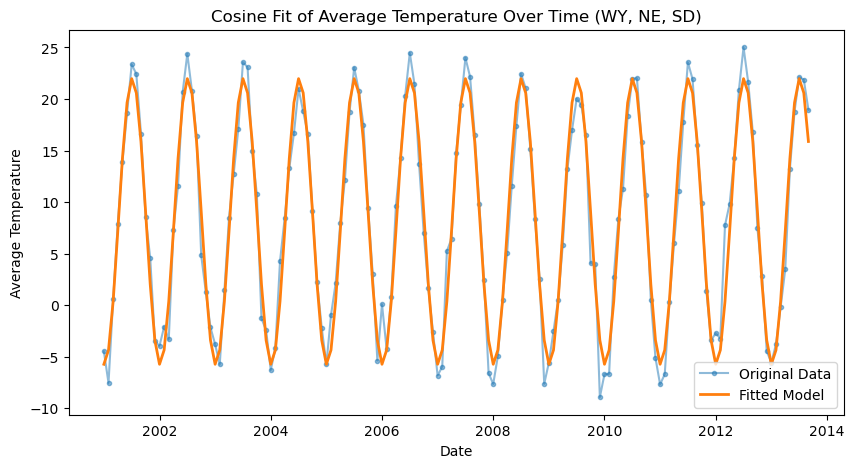

In [336]:
plt.figure(figsize=(10,5))
plt.plot(avg_temp_df["ConvertedDate"], avg_temp_df["AverageTemperature"], label="Original Data", marker=".", alpha=0.5)
plt.plot(avg_temp_df["ConvertedDate"], y_est, label="Fitted Model", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Average Temperature")
plt.title("Cosine Fit of Average Temperature Over Time (WY, NE, SD)")
plt.legend()
plt.show()

In [338]:
error_A = covar[0][0] ** 0.5
error_B = covar[1][1] ** 0.5
error_C = covar[2][2] ** 0.5
error_D = covar[3][3] ** 0.5

In [340]:
print(f"A = {params[0]} ± {error_A}")
print(f"B = {params[1]} ± {error_B}")
print(f"C = {params[2]} ± {error_C}")
print(f"D = {params[3]} ± {error_D}")

A = -13.88353111161459 ± 0.22629174441460187
B = 6.28309822333765 ± 0.004494998250078884
C = 0.10614456742289294 ± 9.018176064270882
D = 8.127814777838294 ± 0.16050135556148493


In [342]:
print(f"T = {params[0]}cos({params[1]}(t)+{params[2]}) + {params[3]}")

T = -13.88353111161459cos(6.28309822333765(t)+0.10614456742289294) + 8.127814777838294


In [344]:
from astropy.table import Table

t = Table.read("global_SF6_MM.dat", format="ascii")
df = t.to_pandas()
df = df.iloc[:, [0, -2, -1]]
df.columns = ["Date", "Global Mean Concentration", "Global Mean Concentration SD"]
df

,Date,Global Mean Concentration,Global Mean Concentration SD
0,1995,3.370,0.064
1,1995,3.397,0.122
2,1995,3.401,0.100
3,1995,3.453,0.094
4,1995,3.467,0.099
...,...,...,...
223,2013,NaN,NaN
224,2013,NaN,NaN
225,2013,NaN,NaN
226,2013,NaN,NaN


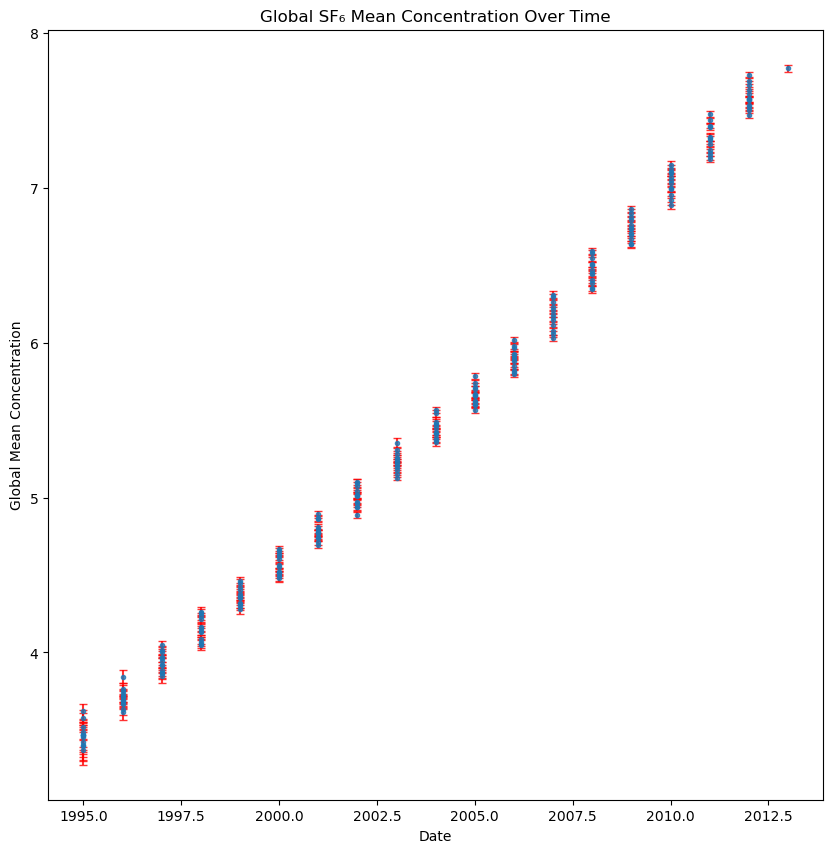

In [346]:
plt.figure(figsize=(10,10))
plt.errorbar(df["Date"], df["Global Mean Concentration"], yerr=df["Global Mean Concentration SD"],
             fmt="o", markersize=3, capsize = 3, alpha = 0.8, ecolor="red")
plt.xlabel("Date")
plt.ylabel("Global Mean Concentration")
plt.title("Global SF₆ Mean Concentration Over Time")
plt.show()

In [348]:
df = df.dropna()
x = df["Date"]
y = df["Global Mean Concentration"]
yerr = df["Global Mean Concentration SD"]

params, cov = np.polyfit(x, y, deg=1, w=1/yerr, cov=True)
m, b = params
error_m = cov[0][0] ** 0.5
error_b = cov[1][1] ** 0.5

y_est = m * x + b
chi_squared = np.sum(((y - y_est) / yerr) ** 2)
reduced_chi_squared = chi_squared / (len(x) - 2)

print(f"slope(m) = {m} ± {error_m}")
print(f"intercept(b) = {b} ± {error_b}")
print(f"estimated y = {m}(x){b}")
print(f"reduced χ² = {reduced_chi_squared}")

slope(m) = 0.2427270828834166 ± 0.0015929346236724996
intercept(b) = -480.90289723882313 ± 3.1937752628006635
estimated y = 0.2427270828834166(x)-480.90289723882313
reduced χ² = 20.830336822987334


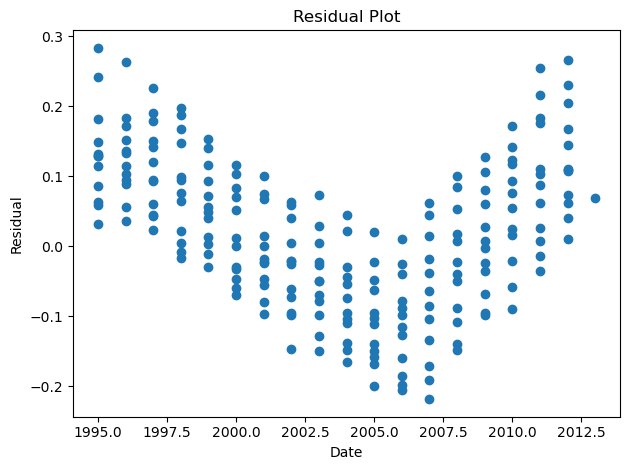

In [350]:
residuals = y - y_est

plt.scatter(x, residuals)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

Since the residual plot shows an obvious pattern, it suggests that linear model is not that appropriate.